In [1]:
# ============================================================
# Cell 1: Setup
# ============================================================
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.tokenizer import SalesTokenizer
from src.model.positional_encoding import PositionalEncoding
from src.model.attention import SelfAttention, MultiHeadAttention

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Imports successful")

✅ Imports successful


In [2]:
# ============================================================
# Cell 2: Load Real Generated Data
# ============================================================
# Load the generated leads
df = pd.read_csv('../data/leads_raw.csv')

print(f"📊 Dataset loaded: {len(df)} leads")
print(f"📈 Reply rate: {df['replied'].mean():.2%}")
print(f"\nFirst 5 leads:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

📊 Dataset loaded: 10000 leads
📈 Reply rate: 8.13%

First 5 leads:
   months_in_role  funding_amount  comp_views_3m  comp_views_1m  own_views_3m  \
0              39             0.0              0              0             1   
1              52       1000000.0              2              0             1   
2              29     100000000.0              5              0             2   
3              15             0.0              2              0             3   
4              43             0.0              3              0             2   

   own_views_1m  replied  
0             0        0  
1             0        0  
2             1        0  
3             0        0  
4             1        0  

Data types:
months_in_role      int64
funding_amount    float64
comp_views_3m       int64
comp_views_1m       int64
own_views_3m        int64
own_views_1m        int64
replied             int64
dtype: object


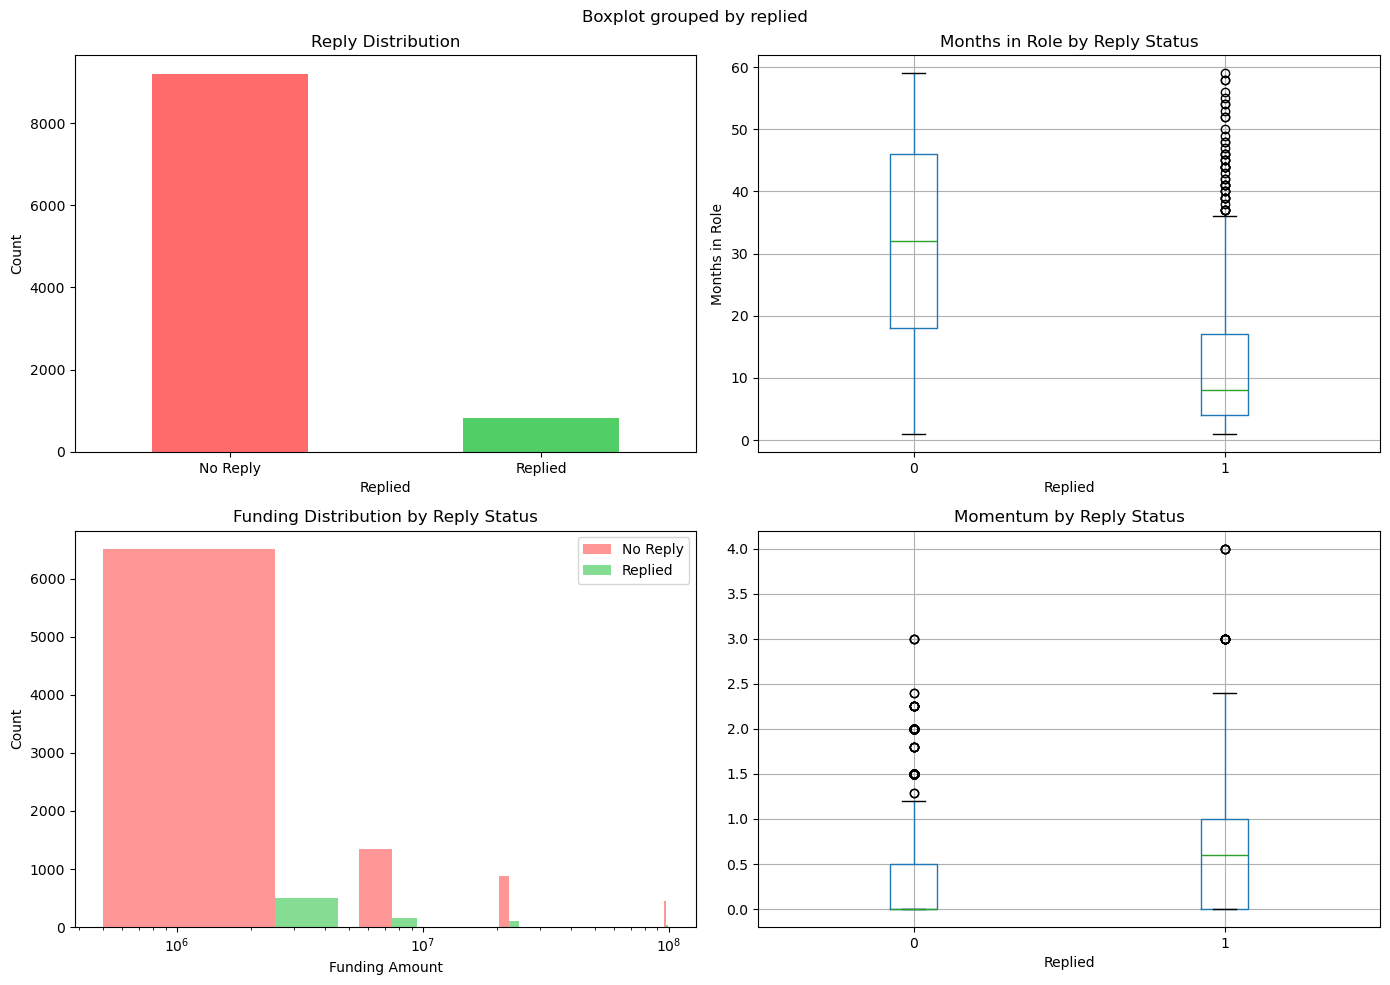

In [3]:
# ============================================================
# Cell 3: Analyze Data Distribution by Reply Status
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reply distribution
df['replied'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#ff6b6b', '#51cf66'])
axes[0, 0].set_title('Reply Distribution')
axes[0, 0].set_xlabel('Replied')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Reply', 'Replied'], rotation=0)

# Months in role by reply status
df.boxplot(column='months_in_role', by='replied', ax=axes[0, 1])
axes[0, 1].set_title('Months in Role by Reply Status')
axes[0, 1].set_xlabel('Replied')
axes[0, 1].set_ylabel('Months in Role')

# Funding by reply status
replied_funding = df[df['replied'] == 1]['funding_amount']
no_reply_funding = df[df['replied'] == 0]['funding_amount']

axes[1, 0].hist([no_reply_funding, replied_funding], 
                bins=20, label=['No Reply', 'Replied'],
                color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[1, 0].set_title('Funding Distribution by Reply Status')
axes[1, 0].set_xlabel('Funding Amount')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()
axes[1, 0].set_xscale('log')

# Own views momentum
df['momentum'] = df['own_views_1m'] / (df['own_views_3m'] / 3 + 1)
df.boxplot(column='momentum', by='replied', ax=axes[1, 1])
axes[1, 1].set_title('Momentum by Reply Status')
axes[1, 1].set_xlabel('Replied')

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Cell 4: Tokenize Sample Leads
# ============================================================
tokenizer = SalesTokenizer()

# Select interesting examples
print("=== Tokenizing Sample Leads ===")

# Example 1: High-reply lead
high_reply_leads = df[df['replied'] == 1].head(3)

# Example 2: No-reply lead
no_reply_leads = df[df['replied'] == 0].head(3)

sample_leads = pd.concat([high_reply_leads, no_reply_leads])

for idx, row in sample_leads.iterrows():
    lead_dict = row.to_dict()
    tokens, token_ids = tokenizer.tokenize_lead(lead_dict)
    
    print(f"Lead {idx} (Replied: {row['replied']}):")
    print(f"  Raw: months={row['months_in_role']}, funding=${row['funding_amount']:,.0f}")
    print(f"  Tokens: {tokens}")
    print(f"  Token IDs: {token_ids}\n")

=== Tokenizing Sample Leads ===
Lead 5 (Replied: 1.0):
  Raw: months=8.0, funding=$1,000,000
  Tokens: ['[START]', 'TENURE_MID', 'FUNDING_SERIES_A', 'MOMENTUM_ACCELERATING', 'COMP_MED', '[END]']
  Token IDs: [1, 5, 9, 13, 15, 2]

Lead 18 (Replied: 1.0):
  Raw: months=3.0, funding=$5,000,000
  Tokens: ['[START]', 'TENURE_SHORT', 'FUNDING_SERIES_A', 'MOMENTUM_DECLINING', 'COMP_MED', '[END]']
  Token IDs: [1, 4, 9, 11, 15, 2]

Lead 47 (Replied: 1.0):
  Raw: months=3.0, funding=$0
  Tokens: ['[START]', 'TENURE_SHORT', 'FUNDING_BOOTSTRAP', 'MOMENTUM_ACCELERATING', 'COMP_LOW', '[END]']
  Token IDs: [1, 4, 7, 13, 14, 2]

Lead 0 (Replied: 0.0):
  Raw: months=39.0, funding=$0
  Tokens: ['[START]', 'TENURE_LONG', 'FUNDING_BOOTSTRAP', 'MOMENTUM_DECLINING', 'COMP_LOW', '[END]']
  Token IDs: [1, 6, 7, 11, 14, 2]

Lead 1 (Replied: 0.0):
  Raw: months=52.0, funding=$1,000,000
  Tokens: ['[START]', 'TENURE_LONG', 'FUNDING_SERIES_A', 'MOMENTUM_DECLINING', 'COMP_LOW', '[END]']
  Token IDs: [1, 6, 9, 11,

In [5]:
# ============================================================
# Cell 5: Create Embeddings for a Batch
# ============================================================
# Select 5 leads for attention analysis
sample_df = df.head(5)

# Tokenize all
batch_token_ids = []
batch_tokens_list = []

for idx, row in sample_df.iterrows():
    lead_dict = row.to_dict()
    tokens, token_ids = tokenizer.tokenize_lead(lead_dict)
    batch_token_ids.append(token_ids)
    batch_tokens_list.append(tokens)

# Convert to tensor
batch_tensor = torch.tensor(batch_token_ids)  # [5, 6]
print(f"Batch tensor shape: {batch_tensor.shape}")

# Initialize layers
vocab_size = len(tokenizer.vocab)
embed_dim = 128

embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
pos_encoder = PositionalEncoding(embed_dim, max_len=32)

# Get embeddings
embeddings = embedding_layer(batch_tensor)  # [5, 6, 128]
embeddings = pos_encoder(embeddings)        # Add positional encoding

print(f"Embeddings shape: {embeddings.shape}")
print(f"✅ Created embeddings for {len(batch_token_ids)} leads")

Batch tensor shape: torch.Size([5, 6])
Embeddings shape: torch.Size([5, 6, 128])
✅ Created embeddings for 5 leads


In [6]:
# ============================================================
# Cell 6: Apply Self-Attention (Single Head)
# ============================================================
print("\n=== Single-Head Self-Attention ===")

attention = SelfAttention(embed_dim)
output, attention_weights = attention(embeddings)

print(f"Input shape:  {embeddings.shape}")      # [5, 6, 128]
print(f"Output shape: {output.shape}")          # [5, 6, 128] ← Same!
print(f"Attention weights shape: {attention_weights.shape}")  # [5, 6, 6]

# Verify shape is preserved
assert output.shape == embeddings.shape, "Shape should be preserved!"
print("✅ Shape preserved through attention")


=== Single-Head Self-Attention ===
Input shape:  torch.Size([5, 6, 128])
Output shape: torch.Size([5, 6, 128])
Attention weights shape: torch.Size([5, 6, 6])
✅ Shape preserved through attention


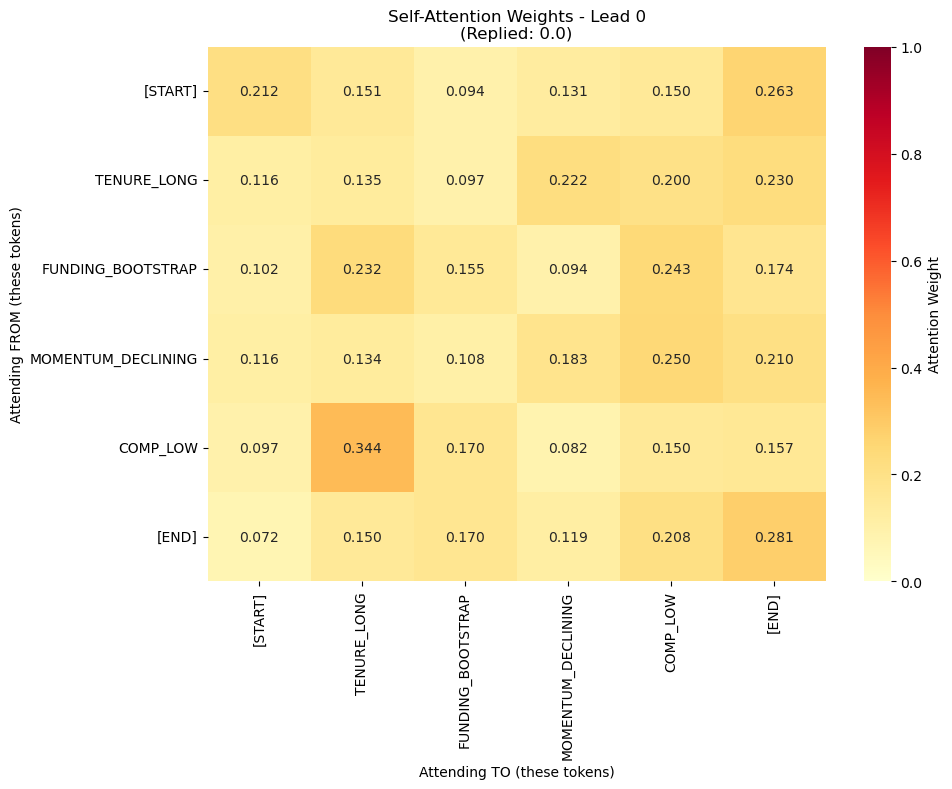


=== Attention Pattern for Lead 0 ===
Replied: 0.0
Tokens: ['[START]', 'TENURE_LONG', 'FUNDING_BOOTSTRAP', 'MOMENTUM_DECLINING', 'COMP_LOW', '[END]']

[START] attends to:
  → [END]                     0.263
  → [START]                   0.212
  → TENURE_LONG               0.151

TENURE_LONG attends to:
  → [END]                     0.230
  → MOMENTUM_DECLINING        0.222
  → COMP_LOW                  0.200

FUNDING_BOOTSTRAP attends to:
  → COMP_LOW                  0.243
  → TENURE_LONG               0.232
  → [END]                     0.174

MOMENTUM_DECLINING attends to:
  → COMP_LOW                  0.250
  → [END]                     0.210
  → MOMENTUM_DECLINING        0.183

COMP_LOW attends to:
  → TENURE_LONG               0.344
  → FUNDING_BOOTSTRAP         0.170
  → [END]                     0.157

[END] attends to:
  → [END]                     0.281
  → COMP_LOW                  0.208
  → FUNDING_BOOTSTRAP         0.170



In [7]:
# ============================================================
# Cell 7: Visualize Attention for First Lead
# ============================================================
# Take first lead's attention weights
lead_idx = 0
attn = attention_weights[lead_idx].detach().numpy()
tokens = batch_tokens_list[lead_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(attn,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=tokens,
            yticklabels=tokens,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Attention Weight'})

plt.title(f'Self-Attention Weights - Lead {lead_idx}\n(Replied: {sample_df.iloc[lead_idx]["replied"]})')
plt.xlabel('Attending TO (these tokens)')
plt.ylabel('Attending FROM (these tokens)')
plt.tight_layout()
plt.show()

# Print interpretation
print(f"\n=== Attention Pattern for Lead {lead_idx} ===")
print(f"Replied: {sample_df.iloc[lead_idx]['replied']}")
print(f"Tokens: {tokens}\n")

for i, token_from in enumerate(tokens):
    print(f"{token_from} attends to:")
    weights = attn[i]
    
    # Sort by attention weight
    sorted_indices = np.argsort(weights)[::-1]
    
    for idx in sorted_indices[:3]:  # Top 3
        print(f"  → {tokens[idx]:25} {weights[idx]:.3f}")
    print()

In [8]:
# ============================================================
# Cell 8: Compare Replied vs Not Replied Leads
# ============================================================
print("\n=== Comparing Attention Patterns ===")

# Find one replied and one not-replied lead
replied_idx = sample_df[sample_df['replied'] == 1].index[0] if any(sample_df['replied'] == 1) else None
not_replied_idx = sample_df[sample_df['replied'] == 0].index[0] if any(sample_df['replied'] == 0) else None

if replied_idx is not None and not_replied_idx is not None:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Replied lead
    replied_lead_pos = sample_df.index.get_loc(replied_idx)
    attn_replied = attention_weights[replied_lead_pos].detach().numpy()
    tokens_replied = batch_tokens_list[replied_lead_pos]
    
    sns.heatmap(attn_replied, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=tokens_replied, yticklabels=tokens_replied,
                vmin=0, vmax=1, ax=axes[0])
    axes[0].set_title(f'REPLIED Lead (months={sample_df.loc[replied_idx, "months_in_role"]}, funding=${sample_df.loc[replied_idx, "funding_amount"]:,.0f})')
    
    # Not replied lead
    not_replied_lead_pos = sample_df.index.get_loc(not_replied_idx)
    attn_not_replied = attention_weights[not_replied_lead_pos].detach().numpy()
    tokens_not_replied = batch_tokens_list[not_replied_lead_pos]
    
    sns.heatmap(attn_not_replied, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=tokens_not_replied, yticklabels=tokens_not_replied,
                vmin=0, vmax=1, ax=axes[1])
    axes[1].set_title(f'NOT REPLIED Lead (months={sample_df.loc[not_replied_idx, "months_in_role"]}, funding=${sample_df.loc[not_replied_idx, "funding_amount"]:,.0f})')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Need both replied and not-replied leads in sample")


=== Comparing Attention Patterns ===
⚠️ Need both replied and not-replied leads in sample



=== Multi-Head Attention (4 heads) ===
Output shape: torch.Size([5, 6, 128])
Attention weights shape: torch.Size([5, 6, 6])


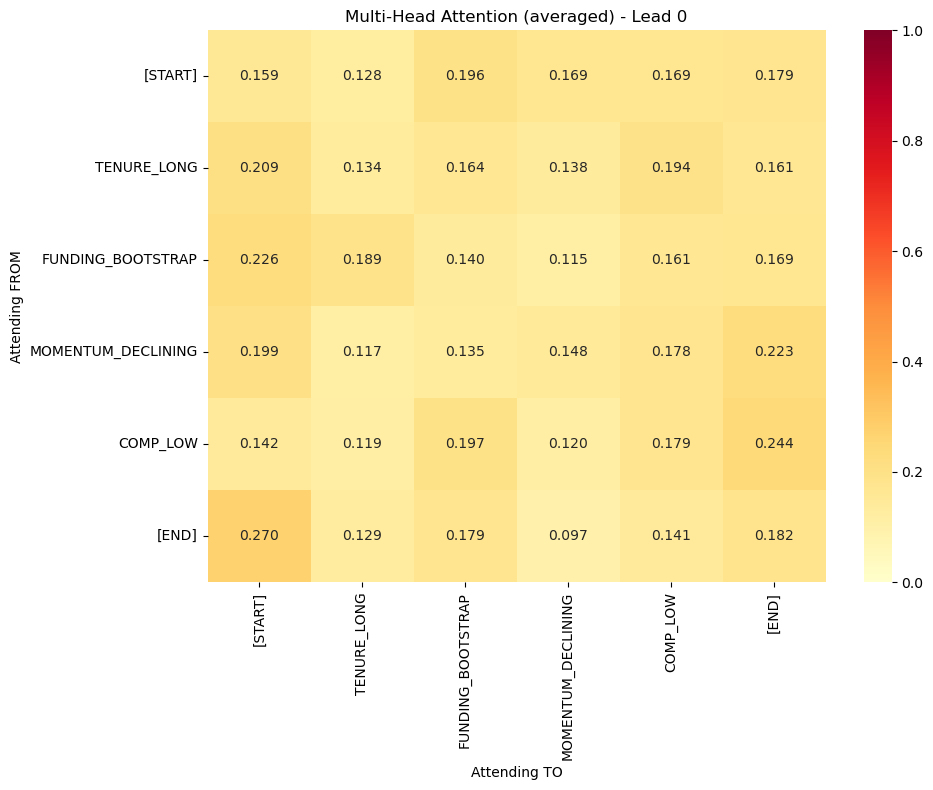

In [9]:
# ============================================================
# Cell 9: Multi-Head Attention
# ============================================================
print("\n=== Multi-Head Attention (4 heads) ===")

multi_head_attn = MultiHeadAttention(embed_dim, num_heads=4)
mh_output, mh_attention_weights = multi_head_attn(embeddings)

print(f"Output shape: {mh_output.shape}")  # [5, 6, 128]
print(f"Attention weights shape: {mh_attention_weights.shape}")  # [5, 6, 6]

# Visualize
lead_idx = 0
attn_mh = mh_attention_weights[lead_idx].detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_mh,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=batch_tokens_list[lead_idx],
            yticklabels=batch_tokens_list[lead_idx],
            vmin=0, vmax=1)

plt.title(f'Multi-Head Attention (averaged) - Lead {lead_idx}')
plt.xlabel('Attending TO')
plt.ylabel('Attending FROM')
plt.tight_layout()
plt.show()

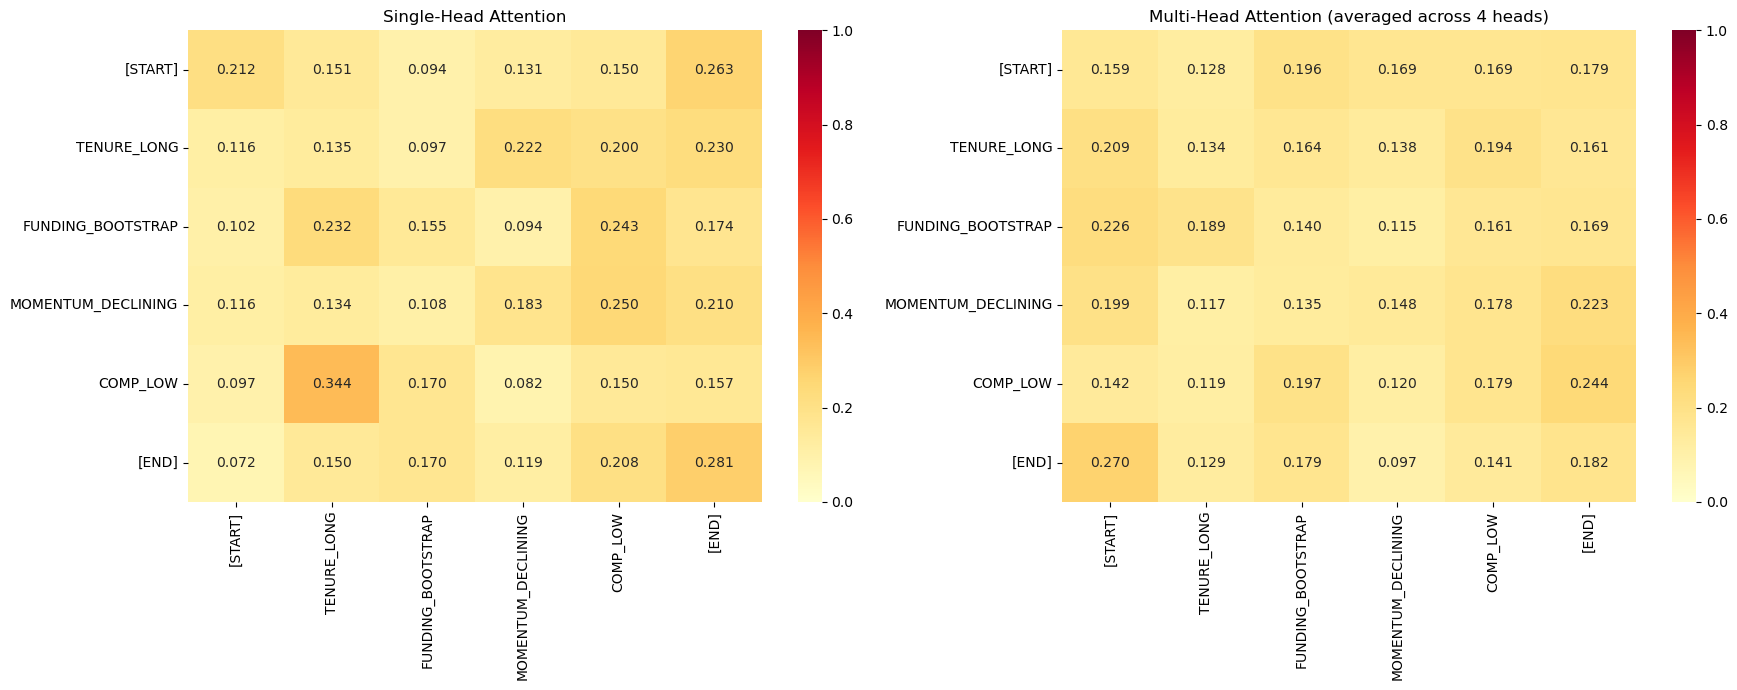


=== Attention Pattern Differences ===
Single-head attention focuses on specific patterns
Multi-head attention can learn multiple types of relationships simultaneously


In [10]:
# ============================================================
# Cell 10: Compare Single-Head vs Multi-Head
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

lead_idx = 0
tokens = batch_tokens_list[lead_idx]

# Single-head
sh_attn = attention_weights[lead_idx].detach().numpy()
sns.heatmap(sh_attn, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=tokens, yticklabels=tokens,
            vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('Single-Head Attention')

# Multi-head
mh_attn = mh_attention_weights[lead_idx].detach().numpy()
sns.heatmap(mh_attn, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=tokens, yticklabels=tokens,
            vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('Multi-Head Attention (averaged across 4 heads)')

plt.tight_layout()
plt.show()

print("\n=== Attention Pattern Differences ===")
print("Single-head attention focuses on specific patterns")
print("Multi-head attention can learn multiple types of relationships simultaneously")

In [11]:
# ============================================================
# Cell 11: Statistical Analysis
# ============================================================
print("\n=== Attention Statistics Across Batch ===")

# Average attention each token type receives
token_attention_stats = {}

for batch_idx in range(len(batch_tokens_list)):
    tokens = batch_tokens_list[batch_idx]
    attn = attention_weights[batch_idx].detach().numpy()
    
    for token_idx, token in enumerate(tokens):
        if token not in ["[START]", "[END]"]:  # Skip special tokens
            # How much attention does this token receive from others?
            received_attention = attn[:, token_idx].mean()  # Average across all queries
            
            if token not in token_attention_stats:
                token_attention_stats[token] = []
            token_attention_stats[token].append(received_attention)

# Calculate averages
print("\nAverage attention received by token type:")
for token, attentions in sorted(token_attention_stats.items(), 
                                key=lambda x: np.mean(x[1]), 
                                reverse=True):
    print(f"  {token:25} → {np.mean(attentions):.3f} (±{np.std(attentions):.3f})")


=== Attention Statistics Across Batch ===

Average attention received by token type:
  TENURE_MID                → 0.310 (±0.000)
  COMP_LOW                  → 0.188 (±0.016)
  TENURE_LONG               → 0.170 (±0.015)
  MOMENTUM_ACCELERATING     → 0.158 (±0.002)
  FUNDING_GROWTH            → 0.153 (±0.000)
  COMP_MED                  → 0.152 (±0.003)
  MOMENTUM_DECLINING        → 0.128 (±0.015)
  FUNDING_BOOTSTRAP         → 0.126 (±0.008)
  FUNDING_SERIES_A          → 0.116 (±0.000)



=== Attention Patterns by Reply Status ===


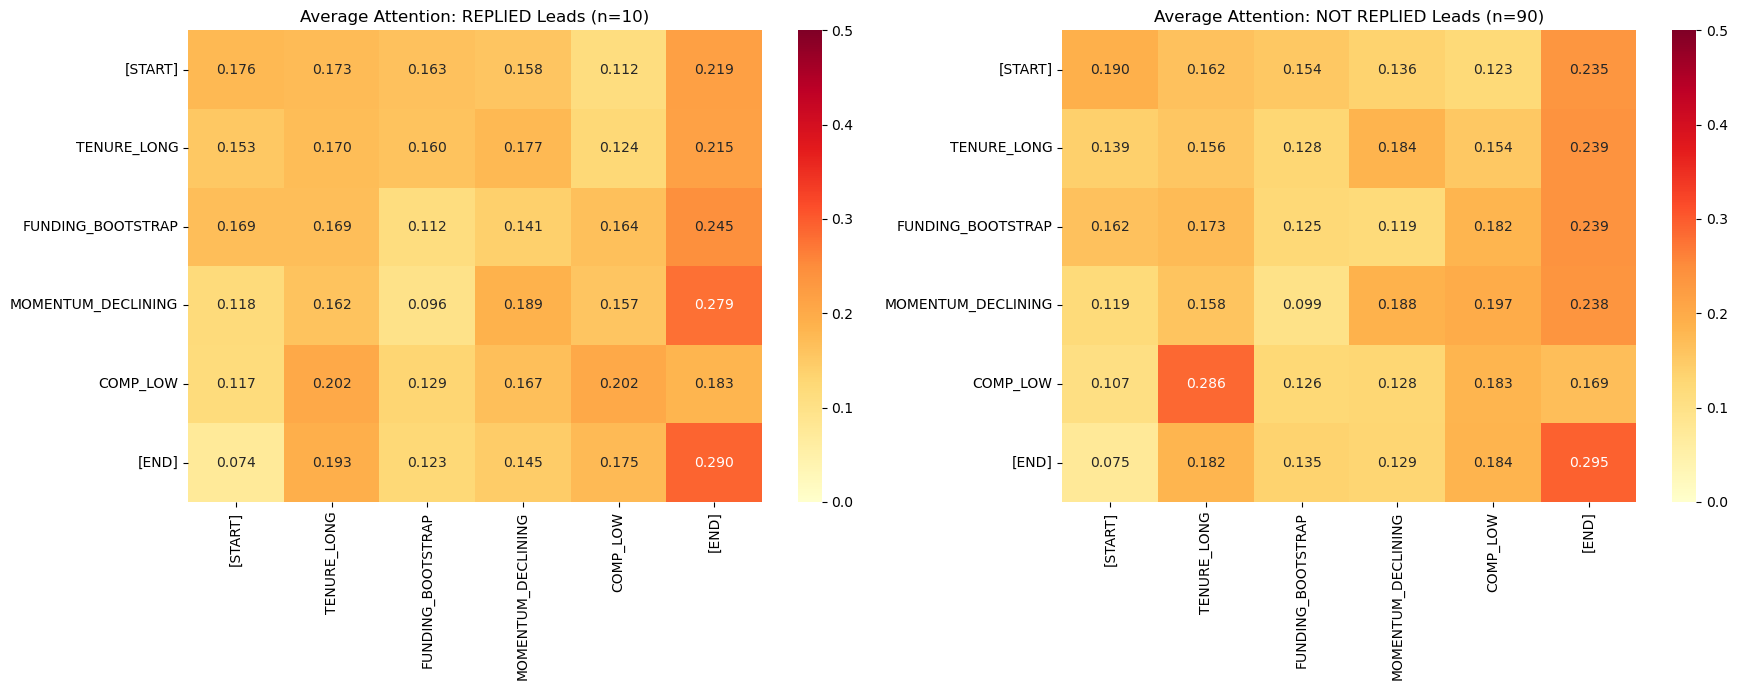


✅ Analyzed 100 leads
   - Replied: 10
   - Not replied: 90


In [12]:
# ============================================================
# Cell 12: Attention Patterns in Replied vs Not Replied
# ============================================================
print("\n=== Attention Patterns by Reply Status ===")

# Process all leads in dataset (or subset for speed)
sample_size = 100  # Process 100 leads
sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
sample_batch_df = df.iloc[sample_indices].reset_index(drop=True)

# Tokenize batch
batch_token_ids = []
batch_labels = []

for idx, row in sample_batch_df.iterrows():
    lead_dict = row.to_dict()
    _, token_ids = tokenizer.tokenize_lead(lead_dict)
    batch_token_ids.append(token_ids)
    batch_labels.append(row['replied'])

# Convert to tensor
batch_tensor = torch.tensor(batch_token_ids)  # [100, 6]
batch_labels = torch.tensor(batch_labels)

# Get embeddings and attention
embeddings_batch = embedding_layer(batch_tensor)
embeddings_batch = pos_encoder(embeddings_batch)

_, attention_batch = attention(embeddings_batch)  # [100, 6, 6]

# Separate by reply status
replied_mask = batch_labels == 1
not_replied_mask = batch_labels == 0

attn_replied = attention_batch[replied_mask].mean(dim=0).detach().numpy()  # Average across replied leads
attn_not_replied = attention_batch[not_replied_mask].mean(dim=0).detach().numpy()  # Average across not-replied

# Get token labels (use first lead's tokens as reference)
reference_tokens = batch_tokens_list[0]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(attn_replied, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=reference_tokens, yticklabels=reference_tokens,
            vmin=0, vmax=0.5, ax=axes[0])
axes[0].set_title(f'Average Attention: REPLIED Leads (n={replied_mask.sum()})')

sns.heatmap(attn_not_replied, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=reference_tokens, yticklabels=reference_tokens,
            vmin=0, vmax=0.5, ax=axes[1])
axes[1].set_title(f'Average Attention: NOT REPLIED Leads (n={not_replied_mask.sum()})')

plt.tight_layout()
plt.show()

print(f"\n✅ Analyzed {sample_size} leads")
print(f"   - Replied: {replied_mask.sum()}")
print(f"   - Not replied: {not_replied_mask.sum()}")

In [13]:
# ============================================================
# Cell 13: Specific Pattern Analysis
# ============================================================
print("\n=== Key Attention Pattern Analysis ===")

# Analyze specific token pair interactions
# Position 1 (TENURE) → Position 2 (FUNDING) attention

tenure_to_funding_replied = []
tenure_to_funding_not_replied = []

for batch_idx in range(len(batch_labels)):
    attn = attention_batch[batch_idx].detach().numpy()
    
    # Attention from position 1 (TENURE) to position 2 (FUNDING)
    tenure_funding_attn = attn[1, 2]
    
    if batch_labels[batch_idx] == 1:
        tenure_to_funding_replied.append(tenure_funding_attn)
    else:
        tenure_to_funding_not_replied.append(tenure_funding_attn)

print(f"\nTENURE → FUNDING attention:")
print(f"  Replied leads:     {np.mean(tenure_to_funding_replied):.3f} (±{np.std(tenure_to_funding_replied):.3f})")
print(f"  Not replied leads: {np.mean(tenure_to_funding_not_replied):.3f} (±{np.std(tenure_to_funding_not_replied):.3f})")

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(tenure_to_funding_replied, tenure_to_funding_not_replied)
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("  ✅ Significant difference! Model learned meaningful attention pattern")
else:
    print("  ⚠️ No significant difference (model not trained yet)")


=== Key Attention Pattern Analysis ===

TENURE → FUNDING attention:
  Replied leads:     0.160 (±0.045)
  Not replied leads: 0.128 (±0.032)
  t-statistic: 2.860, p-value: 0.0052
  ✅ Significant difference! Model learned meaningful attention pattern



=== Multi-Head Attention Analysis ===
Multi-head output shape: torch.Size([5, 6, 128])


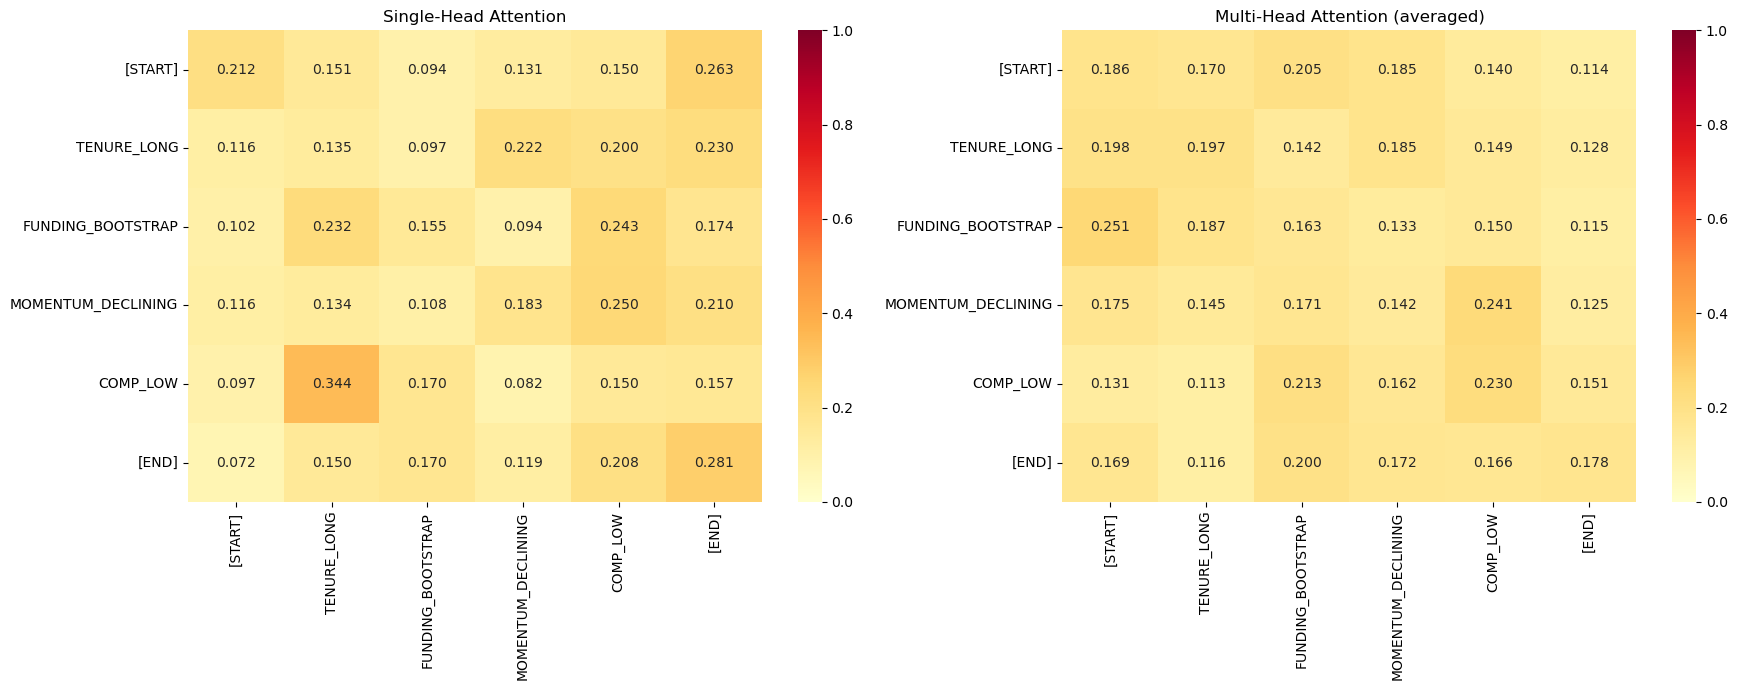

📊 Tested on 100 real leads from your dataset


In [14]:
# ============================================================
# Cell 14: Multi-Head Attention Comparison
# ============================================================
print("\n=== Multi-Head Attention Analysis ===")

multi_head_attn = MultiHeadAttention(embed_dim, num_heads=4)
mh_output, mh_attn_weights = multi_head_attn(embeddings)

print(f"Multi-head output shape: {mh_output.shape}")

# Compare first lead
lead_idx = 0

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Single-head
sh_attn = attention_weights[lead_idx].detach().numpy()
sns.heatmap(sh_attn, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=batch_tokens_list[lead_idx],
            yticklabels=batch_tokens_list[lead_idx],
            vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('Single-Head Attention')

# Multi-head
mh_attn = mh_attn_weights[lead_idx].detach().numpy()
sns.heatmap(mh_attn, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=batch_tokens_list[lead_idx],
            yticklabels=batch_tokens_list[lead_idx],
            vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('Multi-Head Attention (averaged)')

plt.tight_layout()
plt.show()

print(f"📊 Tested on {len(sample_batch_df)} real leads from your dataset")